# Thai Sentence Spacing Classification

**The model is trained to classify the space seen in Thai language
The space in Thai language have 2 class**
1. The space between words and other language/numbers <br>
    eg. วันนี้แม่ซื้อกับข้าวมา 3 ถุง
2. The space between sentence <br>
    eg. ฉันชอบไปโรงเรียน ฉันเลยมักจะไปโรงเรียนเช้ากว่าใครๆในห้อง
    

In [121]:
import xml.etree.ElementTree as ET
import numpy as np

# 1. Data Preparations

In [122]:
xml_file = ET.parse('./xmlchid-cut-sentence.xml')
corpus = xml_file.getroot()
print(len(corpus))

164


In [123]:
documents = []
for docs in corpus:
    documents.append(docs)
print('number of documents in corpus :', len(documents))

number of documents in corpus : 164


In [124]:
CONTEXT_LENGTH = 4

## still hard coded (refactor needed.)
NUM_WORDS = 17050

In [125]:
#LABEL 0  ==> SPACE IN THE SENTENCE
#LABEL 1  ==> SPACE BETWEEN SENTENCES
#LABEL -1 ==> NOT THE SPACE (NOT USED) CAN BE REPLACE BY ANYTHING...

paragraphs_list = []
postags_list = []
tokens_label_list = []
word_counter = 0
pos_counter = 0
word_vocabulary = {}
pos_vocabulary = {}


for doc in documents:
    for paragraph in doc:
        sentences_list = []
        postokens_list = []
        labels_list = []
        
        #append padding token for each paragraph (start)
        for padding in range(CONTEXT_LENGTH):
            sentences_list.append(['<padding>'])
            postokens_list.append(['PADD'])
            labels_list.append(-1)
            
        for i, sentence in enumerate(paragraph):
            for word in sentence:
                token = [word.get('surface')]
                sentences_list.append(token)
                
                
                pos_token = [word.get('pos')]
                postokens_list.append(pos_token)
                
                # add word and tags to dictionary
                if(token[0] not in word_vocabulary):
                    word_vocabulary[token[0]] = word_counter
                    word_counter += 1
                if(pos_token[0] not in pos_vocabulary):
                    pos_vocabulary[pos_token[0]] = pos_counter
                    pos_counter += 1
                
                if (token[0] == '<space>'):
                    labels_list.append(0)
                else:
                    labels_list.append(-1)
                      
            last_sentence_index = len(paragraph) - 1
            if i != last_sentence_index:
                sentences_list.append(['<space>'])
                postokens_list.append(['PUNC'])
            
                labels_list.append(1)
                
        #append padding token for each paragraph (end)
        for padding in range(CONTEXT_LENGTH):
            sentences_list.append(['<padding>'])
            postokens_list.append(['PADD'])
            labels_list.append(-1)       
        paragraphs_list.append(sentences_list)
        postags_list.append(postokens_list)
        tokens_label_list.append(labels_list)

# add spacial tags to the dictionary


pos_vocabulary['PADD'] = pos_counter 
word_vocabulary['<padding>'] = word_counter 

pos_vocabulary['UNNO'] = pos_counter + 1
word_vocabulary['<unknown>'] = word_counter + 1


In [193]:
print('number of paragraphs in corpus :', len(paragraphs_list), '\n')
print('*' * 50, '\n')

print('number of tokenized words of first paragraph :', len(paragraphs_list[0]))
print(paragraphs_list[0], '\n')
print('labels : ', len(tokens_label_list[0]))
print(tokens_label_list[0], '\n')
print('*' * 50, '\n')

print('number of unique vocabulary in corpus :', len(word_vocabulary))
print('ฉัน เป็นคำที่ ...' , word_vocabulary['ฉัน'])
print('ไป เป็นคำที่ ...' , word_vocabulary['ไป'])
print('โรงเรียน เป็นคำที่ ...' , word_vocabulary['โรงเรียน'], '\n')
print('<unknown> เป็นคำที่ ...' , word_vocabulary['<unknown>'], '\n')


print('*' * 50, '\n')

print('number of unique POS tags in corpus :', len(pos_vocabulary))
print(pos_vocabulary)

number of paragraphs in corpus : 11508 

************************************************** 

number of tokenized words of first paragraph : 28
[['<padding>'], ['<padding>'], ['<padding>'], ['<padding>'], ['การ'], ['ประชุม'], ['ทาง'], ['วิชาการ'], ['<space>'], ['ครั้ง'], ['ที่ 1'], ['<space>'], ['โครงการวิจัยและพัฒนา'], ['อิเล็กทรอนิกส์'], ['และ'], ['คอมพิวเตอร์'], ['<space>'], ['ปีงบประมาณ'], ['<space>'], ['2531'], ['<space>'], ['เล่ม'], ['<space>'], ['1'], ['<padding>'], ['<padding>'], ['<padding>'], ['<padding>']] 

labels :  28
[-1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, -1, -1, -1, 1, -1, 0, -1, 1, -1, 0, -1, -1, -1, -1, -1] 

************************************************** 

number of unique vocabulary in corpus : 17050
ฉัน เป็นคำที่ ... 1990
ไป เป็นคำที่ ... 167
โรงเรียน เป็นคำที่ ... 2170 

<unknown> เป็นคำที่ ... 17049 

************************************************** 

number of unique POS tags in corpus : 48
{'FIXN': 0, 'VACT': 1, 'NCMN': 2, 'PUNC': 3, 'CFQC': 4

In [127]:
context_word_list = []
context_pos_list = []
context_answer = []

#find space in paragraph then make context
for i,paragraph in enumerate(paragraphs_list):

    for j, token in enumerate(paragraph):
  
        if(token[0] == '<space>' or token[0] == '<s_space>'):
            context_word = []
            context_pos = []  
            for (k) in range(CONTEXT_LENGTH, 0, -1):

                temp_token = paragraph[j-k]
#                 print(temp_token)
                context_word.append(temp_token)
#                 print(context_word)
                
                temp_token_pos = postags_list[i][j-k]
                context_pos.append(temp_token_pos)
                
            for (l) in range(CONTEXT_LENGTH):
                
                temp_token = paragraph[j+l+1]
                context_word.append(temp_token)

                temp_token_pos = postags_list[i][j+l+1]
                context_pos.append(temp_token_pos)
                
            context_word_list.append(context_word)
            context_pos_list.append(context_pos)
            
            ans = tokens_label_list[i][j]
            context_answer.append(ans)

In [128]:
# MAPPING THE WORD TOKEN TO VALUE IN DICTIONARY

x_word = np.array(context_word_list).reshape(len(context_word_list), CONTEXT_LENGTH * 2)
x_pos = np.array(context_pos_list).reshape(len(context_pos_list), CONTEXT_LENGTH * 2)

x_word_train = []
for i, context in enumerate(x_word):
    context_int = [ word_vocabulary.get(token, NUM_WORDS-1) for token in context]
    x_word_train.append(context_int)

NUM_POS = 48
x_pos_train = []
for i, context in enumerate(x_pos):
    context_int = [ pos_vocabulary.get(token, NUM_POS-1) for token in context]
    x_pos_train.append(context_int)
    
y_train = np.array(context_answer, dtype = np.int8)

x_word_train = np.array(x_word_train)
x_pos_train = np.array(x_pos_train)

print(x_word_train.shape)
print(x_pos_train.shape)
print(y_train.shape)

print(x_word_train[200])
print(x_pos_train[200])

(67562, 8)
(67562, 8)
(67562,)
[17048 17048   175   379   380     4   325 17048]
[46 46 10  9  9  3  2 46]


In [129]:
test_split_ratio = 0.15

test_split_qty  = int(test_split_ratio * len(x_word_train))
train_split_qty = len(x_word_train) - test_split_qty

print(train_split_qty)

57428


In [130]:
# TRAIN <-> TEST SPLITTING... (Capital X and Y)
X_word_train = x_word_train[:train_split_qty]
X_pos_train  = x_pos_train[:train_split_qty]

X_word_test  = x_word_train[train_split_qty : train_split_qty + test_split_qty]
X_pos_test   = x_pos_train[train_split_qty : train_split_qty + test_split_qty]

Y_train      = y_train[:train_split_qty]
Y_test       = y_train[train_split_qty : train_split_qty + test_split_qty]

print('Dataset length = ', len(x_word_train), '\n')

print('x_train len = ', len(X_word_train))
print('y_train len = ', len(Y_train))

print('x_test len = ', len(X_word_test))
print('y_test len = ', len(Y_test))


Dataset length =  67562 

x_train len =  57428
y_train len =  57428
x_test len =  10134
y_test len =  10134


In [131]:
# SAVING DICTIONARY 
import json
with open('./word_vocab.json', 'w') as fp:
    json.dump(word_vocabulary, fp)
    fp.close()

with open('./pos_vocab.json', 'w') as fp2:
    json.dump(pos_vocabulary, fp2)
    fp2.close()

# 2. Embedings Words and POSTags
**Word Embedding: Fasttext**<br>
**\*\*\*SKIP THIS SECTION IF YOU USE EMBEDDING LAYER OF THE MODELS\*\*\***

1. Load fasttext trained thwiki model

In [6]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.th.zip

--2020-11-18 17:16:36--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.th.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2602669751 (2.4G) [application/zip]
Saving to: ‘wiki.th.zip’

wiki.th.zip         100%[===================>]   2.42G  29.3MB/s    in 99s     

2020-11-18 17:18:15 (25.2 MB/s) - ‘wiki.th.zip’ saved [2602669751/2602669751]



In [7]:
!unzip wiki.th.zip

Archive:  wiki.th.zip
  inflating: wiki.th.bin             
  inflating: wiki.th.vec             


In [8]:
import fasttext

In [10]:
fasttext_word_model = fasttext.load_model('wiki.th.bin')
fasttext_word_model.get_dimension()

300

2. Train fasttext postag embedding models and load into notebook

In [17]:
with open('pos_tag_string.txt', 'w') as f:
    for pos_paragraph in postags_list:
        for postag in pos_paragraph:
            f.write("%s " % postag[0])
        f.write("\n")

In [21]:
POS_EMBEDDING_SIZE = 100
CUT_FILE_PATH = './pos_tag_string.txt'
FASTTEXT_MODEL_PATH = './fasttext_model_pos'

In [22]:
!./fastText/fasttext skipgram -input $CUT_FILE_PATH -output $FASTTEXT_MODEL_PATH -dim $POS_EMBEDDING_SIZE

Read 0M words
Number of words:  47
Number of labels: 0
Progress: 100.0% words/sec/thread:  508155 lr:  0.000000 avg.loss:  2.682078 ETA:   0h 0m 0s


In [25]:
fasttext_pos_model = fasttext.load_model(FASTTEXT_MODEL_PATH + '.bin')
fasttext_pos_model.get_dimension()

100

3. Using the model to embed the word and pos token

In [26]:
vec_paragraphs_list = []
vec_postags_list = []

for paragraph in paragraphs_list:
    vec_word = []
    
    for token in paragraph:
        vec = fasttext_word_model.get_word_vector(token[0])
        vec_word.append(vec)
        
    vec_paragraphs_list.append(vec_word)

for pos_paragraph in postags_list:
    vec_pos = []
    
    for pos_token in pos_paragraph:
        vec = fasttext_pos_model.get_word_vector(pos_token[0])
        vec_pos.append(vec)
    
    vec_postags_list.append(vec_pos)

In [33]:
print('length of input set of word vector:', len(vec_paragraphs_list))
print('length of input set of postags vector:',len(vec_postags_list))
print(vec_paragraphs_list[0][0:2])
print(vec_postags_list[0][0:2])

length of input set of word vector: 11508
length of input set of postags vector: 11508
[array([-0.10596462,  0.0534357 ,  0.06850535,  0.19130176,  0.16411081,
        0.02208216, -0.00101554, -0.17886946,  0.00827608,  0.1905343 ,
        0.34671125,  0.03881268,  0.02401338, -0.04681519,  0.33765432,
       -0.091507  ,  0.14224795, -0.0299975 , -0.17347592,  0.32992947,
       -0.00273825, -0.16587082, -0.10390963, -0.253509  , -0.19863504,
        0.35301802,  0.13454908, -0.16305357,  0.20494826,  0.04882457,
        0.09958592, -0.07263525,  0.18276292,  0.40234217,  0.18770188,
        0.01192412,  0.08085598, -0.04850538, -0.1682882 , -0.28915486,
       -0.06991597,  0.04544356,  0.09172125, -0.12690555, -0.02346022,
       -0.16817385,  0.1896465 , -0.19894685,  0.2125472 , -0.15461889,
        0.04662331,  0.11132513, -0.19436818,  0.01263941,  0.15756638,
       -0.05125534, -0.02414097,  0.20323697, -0.13083987,  0.09681961,
       -0.06091405,  0.14629915, -0.07465646,  0

4. Concatination between word_vector and postags_vector (300 + 100 = 400)

In [54]:
input_vector = []
for i in range(len(vec_paragraphs_list)):
    combines_vector = []
    for j in range(len(vec_paragraphs_list[i])):
        
        combine_vector = np.concatenate((vec_paragraphs_list[i][j], vec_postags_list[i][j]))
        combines_vector.append(combine_vector)
    
    input_vector.append(combines_vector)

In [55]:
print(len(input_vector))

11508


# 3.1 The LSTM Models (WORDs with POSTags)

In [21]:
from tensorflow.keras import Model, models
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Input, Bidirectional, Conv1D, MaxPool1D, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

import matplotlib.pyplot as plt

In [22]:
# If you use embedded layer skip the Embedding layer and change input to embeded vector instread!

input_word = Input((CONTEXT_LENGTH * 2,))
x1 = Embedding(NUM_WORDS, 300)(input_word)

input_tag = Input((CONTEXT_LENGTH * 2,))
x2 = Embedding(NUM_WORDS, 100)(input_tag)

x = Concatenate()([x1, x2])

x = MaxPool1D()(x)
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Bidirectional(LSTM(100, return_sequences=False))(x)
x = Dense(32, activation='tanh')(x)
x = Dropout(0.2)(x)
out = Dense(2, activation='softmax')(x)

In [23]:
model = Model([input_word, input_tag], out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 300)       5115000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 8, 100)       1705000     input_2[0][0]                    
_______________________________________________________________________________________

In [24]:
#TRAIN HYPER PARAMETERS 
learning_rate = 0.001

epochs = 5
batch_size = 22 
validation_split = 0.2  # 20%

In [25]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [26]:
history = model.fit([X_word_train, X_pos_train], Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1)


Epoch 1/5
2089/2089 [==============================] - 119s 57ms/step - loss: 0.2731 - accuracy: 0.8858 - val_loss: 0.2399 - val_accuracy: 0.8960
Epoch 2/5
2089/2089 [==============================] - 117s 56ms/step - loss: 0.1547 - accuracy: 0.9380 - val_loss: 0.2599 - val_accuracy: 0.8934
Epoch 3/5
2089/2089 [==============================] - 116s 56ms/step - loss: 0.0904 - accuracy: 0.9652 - val_loss: 0.3091 - val_accuracy: 0.8774
Epoch 4/5
2089/2089 [==============================] - 117s 56ms/step - loss: 0.0539 - accuracy: 0.9806 - val_loss: 0.3760 - val_accuracy: 0.8700
Epoch 5/5
2089/2089 [==============================] - 115s 55ms/step - loss: 0.0366 - accuracy: 0.9870 - val_loss: 0.4784 - val_accuracy: 0.8684


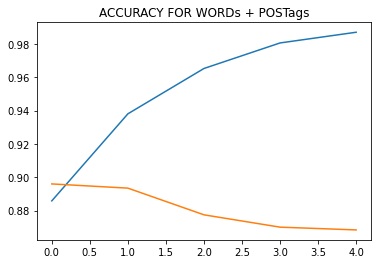

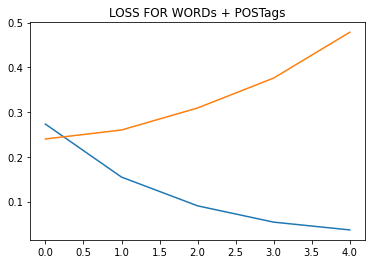

([<matplotlib.lines.Line2D at 0x7fbb5d2d1ad0>], None)

In [27]:
# Training visualization 
plt.title("ACCURACY FOR WORDs + POSTags")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']), plt.show()

plt.title("LOSS FOR WORDs + POSTags")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']), plt.show()

In [28]:
matrix_score = model.evaluate([X_word_test, X_pos_test], Y_test, batch_size = batch_size)

test_loss = matrix_score[0]
test_accuracy = matrix_score[1]

461/461 [==============================] - 3s 7ms/step - loss: 0.4016 - accuracy: 0.8885


In [29]:
print("TEST ACCURACY")
print(test_accuracy*100, '%') 

TEST ACCURACY
88.84941935539246 %


In [30]:
# SAVE FIRST MODEL
MODEL_SAVING_PATH = './th_sentence_spacing_classifier_by_word_and_pos.h5'
model.save(MODEL_SAVING_PATH)

# 3.2 The LSTM Models (only WORDs)

In [31]:
# If you use embedded layer skip the Embedding layer and change input to embeded vector instread!

input_word_2 = Input((CONTEXT_LENGTH * 2,))
x_2 = Embedding(NUM_WORDS, 300)(input_word_2)
x_2 = MaxPool1D()(x_2)
x_2 = Bidirectional(LSTM(100, return_sequences=True))(x_2)
x_2 = Bidirectional(LSTM(100, return_sequences=False))(x_2)
x_2 = Dense(32, activation='tanh')(x_2)
x_2 = Dropout(0.2)(x_2)
out_2 = Dense(2, activation='softmax')(x_2)

In [32]:
model2 = Model(input_word_2, out_2)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 8, 300)            5115000   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 300)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 4, 200)            320800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [33]:
model2.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [34]:
history2 = model2.fit(X_word_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1)


Epoch 1/5
2089/2089 [==============================] - 98s 47ms/step - loss: 0.2994 - accuracy: 0.8753 - val_loss: 0.2679 - val_accuracy: 0.8833
Epoch 2/5
2089/2089 [==============================] - 97s 46ms/step - loss: 0.1648 - accuracy: 0.9355 - val_loss: 0.2768 - val_accuracy: 0.8812
Epoch 3/5
2089/2089 [==============================] - 96s 46ms/step - loss: 0.0941 - accuracy: 0.9649 - val_loss: 0.3333 - val_accuracy: 0.8754
Epoch 4/5
2089/2089 [==============================] - 95s 45ms/step - loss: 0.0574 - accuracy: 0.9786 - val_loss: 0.3922 - val_accuracy: 0.8725
Epoch 5/5
2089/2089 [==============================] - 94s 45ms/step - loss: 0.0371 - accuracy: 0.9870 - val_loss: 0.5254 - val_accuracy: 0.8647


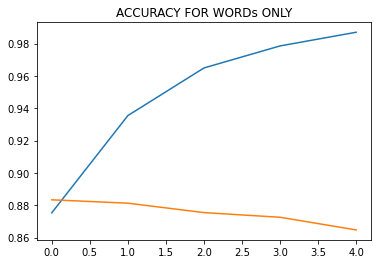

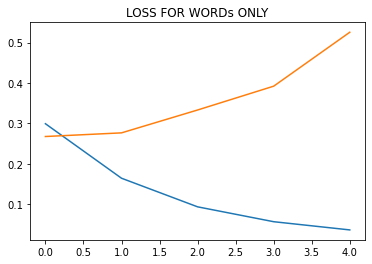

([<matplotlib.lines.Line2D at 0x7fbb3a1dea10>], None)

In [35]:
# Training visualization 
plt.title("ACCURACY FOR WORDs ONLY")
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy']), plt.show()

plt.title("LOSS FOR WORDs ONLY")
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss']), plt.show()

In [36]:
matrix_score2 = model2.evaluate(X_word_test, Y_test, batch_size = batch_size)

test_loss2 = matrix_score2[0]
test_accuracy2 = matrix_score2[1]

461/461 [==============================] - 3s 6ms/step - loss: 0.3967 - accuracy: 0.8929


In [37]:
print("TEST ACCURACY")
print(test_accuracy2*100, '%') 

TEST ACCURACY
89.29346799850464 %


In [163]:
# SAVE SECOND MODEL
MODEL_SAVING_PATH = './th_sentence_spacing_classifier_by_word.h5'
model2.save(MODEL_SAVING_PATH)

# 4. Using The Model

In [124]:
!pip install pythainlp

     |████████████████████████████████| 8.9 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 743 kB 65.7 MB/s eta 0:00:01


In [207]:
def space_guess(paragraph, word_dictionary, model, model_padding_size = 4):
    
    # padding...
    padding = []
    for i in range(model_padding_size):
        padding.append('<padding>')
    paragraph = padding + paragraph + padding
    
    #replace space with token of space
    for i, token in enumerate(paragraph):
        if(token == ' '): paragraph[i] = '<space>'
            
    # find space in paragraph then make context
    context_word_list = []
    for j, token in enumerate(paragraph):
        if(token == '<space>'):
            context_word = [] 
            for (k) in range(model_padding_size, 0, -1):
                temp_token = paragraph[j-k]
                context_word.append([temp_token])

            for (l) in range(CONTEXT_LENGTH):
                temp_token = paragraph[j+l+1]
                context_word.append([temp_token])
            context_word_list.append(context_word)

    x_context = np.array(context_word_list).reshape(len(context_word_list), model_padding_size * 2)

    NUM_WORDS = 17050
    x_context_prediction = []
    for i, context in enumerate(x_context):
        context_int = [ word_dictionary.get(token, NUM_WORDS-1) for token in context]
        x_context_prediction.append(context_int) 

    ans_arr = []
    for i in range(len(x_context_prediction)):

        ans = model.predict(np.array(x_context_prediction[i]).reshape(1,8))

        if(ans[0][0] > 0.5): ans_arr.append('NO')
        else :            ans_arr.append('YES')

    print(ans_arr)
    return ans_arr    


In [208]:
#Load the model
mymodel = models.load_model('./th_sentence_spacing_classifier_by_word.h5')

In [264]:
#Your Paragraph 
myparagraph = "ฉันซื้อขนมซองละ 5 บาท แม่บอกว่าขนมถูกแต่ไม่มีประโยชน์"
myparagraph2 = "เก็บข้อมูลเชิงลึกกับคนไร้บ้านที่มีโรคจิตเวชจำนวน 20 คน ที่พบโรคจิตเวชโรคใดโรคหนึ่ง"
myparagraph3 = "ฉันชอบกินข้าวมากฉันจึงซื้อข้าวมาเก็บไว้เผื่อ แม่บอกว่าในห้องยังเหลืออีกตั้ง 10 กระสอบ"
myparagraph4 = "ฉันชอบเรียนวิชา nlp มาก เพราะว่าอาจารย์ทั้งใจดีแล้วก็สอนเก่งอีกด้วย"

In [265]:
# tokenize your paragraph (use any of tokenizer you wanted)
from pythainlp.tokenize import word_tokenize
myparagraph_token = word_tokenize(myparagraph, engine="newmm")
myparagraph_token2 = word_tokenize(myparagraph2, engine="newmm")
myparagraph_token3 = word_tokenize(myparagraph3, engine="newmm")
myparagraph_token4 = word_tokenize(myparagraph4, engine="newmm")
print(myparagraph_token4)

['ฉัน', 'ชอบ', 'เรียน', 'วิชา', ' ', 'nlp', ' ', 'มาก', ' ', 'เพราะว่า', 'อาจารย์', 'ทั้ง', 'ใจดี', 'แล้วก็', 'สอน', 'เก่ง', 'อีกด้วย']


In [246]:
# Load our dictionary
import json 

# Opening JSON file 
myword_vocab = {}
with open('./word_vocab.json') as json_file:
    myword_vocab = json.load(json_file)
    json_file.close()

In [260]:
# apply to our funtion
print(myparagraph)
ans = space_guess(myparagraph_token, myword_vocab, mymodel, model_padding_size = 4)

ฉันซื้อขนมซองละ 5 บาท แม่บอกว่าขนมถูกแต่ไม่มีประโยชน์
['NO', 'NO', 'YES']


In [261]:
print(myparagraph2)
ans = space_guess(myparagraph_token2, myword_vocab, mymodel, model_padding_size = 4)

เก็บข้อมูลเชิงลึกกับคนไร้บ้านที่มีโรคจิตเวชจำนวน 20 คน ที่พบโรคจิตเวชโรคใดโรคหนึ่ง
['NO', 'NO', 'YES']


In [262]:
print(myparagraph3)
ans = space_guess(myparagraph_token3, myword_vocab, mymodel, model_padding_size = 4)

ฉันชอบกินข้าวมากฉันจึงซื้อข้าวมาเก็บไว้เผื่อ แม่บอกว่าในห้องยังเหลืออีกตั้ง 10 กระสอบ
['YES', 'NO', 'NO']


In [266]:
print(myparagraph4)
ans = space_guess(myparagraph_token4, myword_vocab, mymodel, model_padding_size = 4)

ฉันชอบเรียนวิชา nlp มาก เพราะว่าอาจารย์ทั้งใจดีแล้วก็สอนเก่งอีกด้วย
['NO', 'NO', 'YES']
